In [1]:
import sys

sys.path.append("../")

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

# DATA_PATH = '/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min'
# DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/1h'
DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/fx-bot-research/data/tickstory/1m'

In [3]:
from os import listdir
from os.path import isfile, join
symbols = [f.replace('.csv', '') for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))]
# symbols

In [4]:
# symbols.remove('XAUUSD.csv')
# symbols.remove('XAUUSD_1d.csv')

In [5]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
# symbols = ['AUDUSD', 'EURUSD', 'GBPUSD', 'USDCAD', 'USDJPY']

data = []
start_date = '2022-10-01'
end_date = '2022-12-09'

for symbol in symbols:
    file = f'{DATA_PATH}/{symbol}.csv'
    # print(file)
    df = pd.read_csv(file)
    # df['open_time'] = df['Date'].astype('str') + "T" + df['Timestamp'].astype('str')
    df['open_time'] = pd.to_datetime(df['Date'], format='%Y%m%dT%H:%M:%S')
    df.set_index('open_time', inplace=True)
    df.drop(columns=['Date'], inplace=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    # df = df[(df.index > start_date) & (df.index < end_date)]
    df = df[~df.index.duplicated(keep='first')]

    # print(symbol, df.index[-1])
    df.rename(columns={'close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    data.append(np.log(df[symbol]))

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True, how='any')

df.tail()

,AUDCAD,AUDCHF,AUDJPY,AUDNZD,AUDSGD,AUDUSD,CADCHF,CADHKD,CADJPY,CHFJPY,...,NZDCHF,NZDJPY,NZDSGD,NZDUSD,SGDJPY,USDCAD,USDCHF,USDCNH,USDDKK,USDHUF
open_time,,,,,,,,,,,,,,,,,,,,,
2021-02-17 20:09:00,-0.016292,-0.361817,4.407499,0.075488,0.028782,-0.255228,-0.345622,1.808974,4.423660,4.769209,...,-0.437513,4.331877,-0.046924,-0.330826,4.378458,0.238930,-0.106606,1.862310,1.820810,5.695959
2021-02-17 20:10:00,-0.016272,-0.361889,4.407341,0.075506,0.028811,-0.255215,-0.345693,1.808995,4.423492,4.769099,...,-0.437606,4.331680,-0.046924,-0.330826,4.378295,0.238915,-0.106695,1.862288,1.820753,5.695908
2021-02-17 20:11:00,-0.016211,-0.361788,4.407451,0.075469,0.028898,-0.255099,-0.345664,1.809029,4.423564,4.769141,...,-0.437498,4.331799,-0.046798,-0.330701,4.378320,0.238875,-0.106728,1.862199,1.820656,5.695807
2021-02-17 20:12:00,-0.016282,-0.361831,4.407402,0.075441,0.028850,-0.255150,-0.345650,1.809052,4.423564,4.769133,...,-0.437482,4.331812,-0.046788,-0.330687,4.378307,0.238859,-0.106717,1.862198,1.820729,5.695841
2021-02-17 20:13:00,-0.016262,-0.361874,4.407378,0.075534,0.028830,-0.255163,-0.345693,1.809000,4.423528,4.769133,...,-0.437575,4.331693,-0.046913,-0.330812,4.378270,0.238891,-0.106717,1.862176,1.820700,5.695982


In [6]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    # print("trace_crit_value",trace_crit_value)
    # print("eigen_crit_value",eigen_crit_value)
    # print("lr1",result.lr1)
    # print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [7]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except KeyError:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[175.47883813025365, 31.310193049841548]",AUDCAD,AUDCHF
1,"[230.45717378395057, -13.050314418078576]",AUDCAD,AUDJPY
2,"[292.17027298627454, -80.95792995174452]",AUDCAD,AUDSGD
3,"[349.04053994123495, -106.96251964180773]",AUDCAD,AUDUSD
4,"[206.79748856022107, 31.26536819153248]",AUDCAD,CADCHF


In [8]:
coint_df.to_csv('coint_df.csv')


In [9]:
def calculate_spread(selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        selected_row = i
        hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
        spread = calculate_spread(selected_row, hedge_ratio)
        adf_p = adf_test(spread, verbose=False)
        pp_p = pp_test(spread, verbose=False)
        kpss_p = kpss_test(spread, verbose=False)

        if adf_p < critical_val and pp_p < critical_val and kpss_p > critical_val:
            half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[selected_row].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                'half_life': half_life
            })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
stationary_df.sort_values(by=['half_life'], inplace=True)
stationary_df

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarnin

,i,pairs,half_life
185,242,"[CADHKD, USDCAD]",2
357,512,"[EURNZD, NZDSGD]",17
447,662,"[NZDCHF, NZDSGD]",17
310,431,"[EURHKD, EURUSD]",23
317,441,"[EURHKD, USDDKK]",29
...,...,...,...
163,191,"[AUDUSD, USDDKK]",311
233,314,"[EURAUD, GBPCAD]",328
62,62,"[AUDCHF, GBPCAD]",350
77,80,"[AUDJPY, EURCAD]",371


In [10]:
selected_row = stationary_df['i'].iloc[1]
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
spread = calculate_spread(selected_row, hedge_ratio)

In [11]:
hedge_ratio

array([314.1305606 , 510.77400012])

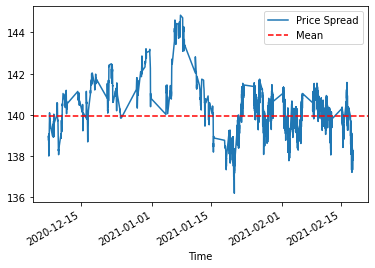

In [12]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [13]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

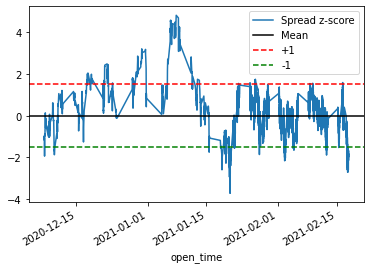

In [14]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.5, color='red', linestyle='--')
plt.axhline(-1.5, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])

In [15]:
zscore(spread).iloc[-1]

-1.700665870732052